# This notebook assumes that you've imported one or more NWB files into DataJoint 
# It allows you to run spikesorters on those data using the SpikeInterface package

#### Load all of the relevant modules

In [2]:
%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
%load_ext autoreload
%autoreload 2

import os
data_dir = '/Users/loren/data/nwb_builder_test_data'
os.environ['NWB_DATAJOINT_BASE_DIR'] = data_dir

os.environ['KACHERY_STORAGE_DIR'] = os.path.join(data_dir, 'kachery-storage')
os.environ['SORTING_TEMP_DIR'] = os.path.join(data_dir, 'sort_tmp')

import pynwb
import os

#DataJoint and DataJoint schema
import nwb_datajoint as nd
import datajoint as dj

import spikeinterface as si
import spikeextractors as se

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


17:59:12 [I] klustakwik KlustaKwik2 version 0.2.6


### Set the nwb file name and the name of the probe file to create from DataJoint

In [3]:
nwb_file_name = (nd.common.Session() & {'session_id': 'beans_01'}).fetch1('nwb_file_name')
#probe_file_name = '/Users/loren/data/nwb_builder_test_data/test.prb'

### Set the sort grouping by shank

In [9]:
nd.common.SortGroup().set_group_by_shank(nwb_file_name)


About to delete:
`common_ephys`.`sort_group__sort_group_electrode`: 256 items
`common_ephys`.`sort_group`: 8 items


Proceed? [yes, No]:  no


Cancelled deletes.


DuplicateError: ("Duplicate entry 'beans20190718.nwb-0' for key 'PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

### create the spike sorter and parameter lists 

In [4]:
nd.common.SpikeSorter().insert_from_spikeinterface()
nd.common.SpikeSorterParameters().insert_from_spikeinterface()

/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/datajoint/blob.py:180: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(obj, collections.ByteString):
/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/datajoint/blob.py:182: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(obj, collections.MutableSequence):
/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/datajoint/blob.py:184: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(obj, collections.Sequence):
/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/datajoint/blob.py:186: Deprecation

### create a 'franklab_mountainsort' parameter set

In [5]:
p = (nd.common.SpikeSorterParameters() & {'sorter_name': 'mountainsort4', 'parameter_set_name' : 'default'}).fetch1()
param = p['parameter_dict']
param['adjacency_radius'] = 100
param['curation'] = True
param['num_workers'] = 8
nd.common.SpikeSorterParameters().insert1({'sorter_name': 'mountainsort4', 'parameter_set_name' : 'franklab_mountainsort', 'parameter_dict' : param}, skip_duplicates='True')

### Create a set of spike sorting parameters for sorting group 2

In [3]:
key = dict()
key['nwb_file_name'] = nwb_file_name
key['sort_group_id'] = 2
key['sorter_name'] = 'mountainsort4'
key['parameter_set_name'] = 'franklab_mountainsort'
key['interval_list_name'] = 'test'
nd.common.SpikeSortingParameters().insert1(key, skip_duplicates='True')

DuplicateError: ("Duplicate entry 'beans20190718.nwb-2-mountainsort4-franklab_mountainsort-test' for key 'PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

In [4]:
nd.common.SpikeSorting().populate()

sample indeces: [       0 11999923]
Sorting {'nwb_file_name': 'beans20190718.nwb', 'sort_group_id': 2, 'sorter_name': 'mountainsort4', 'parameter_set_name': 'franklab_mountainsort', 'interval_list_name': 'test'}...


AttributeError: Bad parameters: ['sorter_name', 'parameter_set_name', 'parameter_dict']

In [7]:
recording = se.NwbRecordingExtractor(nd.common.Nwbfile.get_abs_path(nwb_file_name), electrical_series_name='e-series')



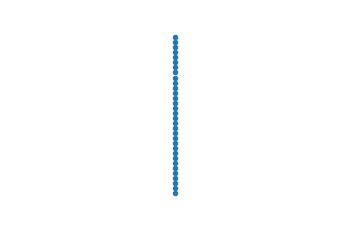

In [16]:
recording = recording.load_probe_file(probe_file_name)

import spikeinterface.widgets as sw
probe = sw.plot_electrode_geometry(recording)
#p = si.widgets.plot_electrode_geometry(recording)

In [93]:
import numpy as np
s1 = ((nd.common.IntervalList() & {'interval_list_name' : '01_s1'}).fetch('valid_times'))
s1


array([array([[1.56348899e+09, 1.56349008e+09]])], dtype=object)

In [11]:
second_shank_electrodes = (nd.common.SortGroup.SortGroupElectrode() & {'nwb_file_name' : nwb_file_name} & {'sort_group_id' : 1}).fetch('electrode_id')
second_shank_electrodes

array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [102]:
valid_times = (nd.common.IntervalList() & {'nwb_file_name' : nwb_file_name, 'interval_list_name' : 'raw data valid times'}).fetch('valid_times')
valid_times[0]

array([[1.56348899e+09, 1.56349008e+09],
       [1.56349063e+09, 1.56349084e+09],
       [1.56349084e+09, 1.56349340e+09],
       [1.56349367e+09, 1.56349502e+09],
       [1.56349543e+09, 1.56349711e+09]])

In [110]:
a = valid_times[0][0,0]
b = a + 600
new_valid_times =np.asarray([[a,b]])
new_valid_times
#nd.common.IntervalList().insert1({'nwb_file_name' : nwb_file_name, 'interval_list_name' : 'test', 'valid_times' : new_valid_times})
nd.common.IntervalList()

nwb_file_name the name of the NWB file,interval_list_name descriptive name of this interval list,valid_times 2D numpy array with start and end times for each interval
beans20190718.nwb,01_s1,=BLOB=
beans20190718.nwb,02_r1,=BLOB=
beans20190718.nwb,03_s2,=BLOB=
beans20190718.nwb,04_r2,=BLOB=
beans20190718.nwb,pos 0 valid times,=BLOB=
beans20190718.nwb,pos 1 valid times,=BLOB=
beans20190718.nwb,pos 2 valid times,=BLOB=
beans20190718.nwb,pos 3 valid times,=BLOB=
beans20190718.nwb,raw data valid times,=BLOB=
beans20190718.nwb,test,=BLOB=


In [32]:
second_shank_recording = se.SubRecordingExtractor(recording, channel_ids=second_shank_electrodes)
second_shank_recording.frame_to_time?

Signature: second_shank_recording.frame_to_time(frame)
Docstring:
This function converts a user-inputted frame index to a time with units of seconds.

Parameters
----------
frame: float
    The frame to be converted to a time

Returns
-------
time: float
    The corresponding time in seconds
File:      ~/Src/NWB/spikeextractors/spikeextractors/subrecordingextractor.py
Type:      method


In [15]:
second_shank_sort = si.sorters.run_mountainsort4(recording=second_shank_recording, **param, grouping_property='group', output_folder='/Users/loren/data/nwb_builder_test_data/tmp')

KeyboardInterrupt: 

In [35]:
a = dict()
a[1] = 'test'

In [36]:
a[1]

'test'